In [62]:
# Install packages not available in the docker image
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import pandas as pd

# Import the 'config' funtion from the config.py file
from config import config

# Establish a connection to the database by creating a cursor object

# Obtain the configuration parameters
params = config()
# Connect to the PostgreSQL database
conn = psycopg2.connect(**params)
# Create a new cursor
cur = conn.cursor()

# A function that takes in a PostgreSQL query and outputs a pandas database 
def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table
  

## 1. Create your raw train and test datasets

In this step, the the required tables were consolidated using SQL JOIN and splitted into both train and test sets respectively. It is important to split the dataset into train and test sets as a precaution step to avoiding data leakage during data transformation.

In [3]:
# Utilize the create_pandas_table function to create a Pandas data frame
# Store the data as a variable
raw_df = create_pandas_table('''
SELECT
   oc.order_id,
   oc.buyer_id,
   b.first_name,
   b.last_name,
   b.email,
   m.name,
   m.created_at merchant_date,
   b.created_at buyers_date,
   oc.merchant_id,
   total_price_cents,
   oc.created_at orders_date,
   od.decision,
   od.due_date,
   od.created_at decision_date,
   op.created_at payment_date,
   d.dataset_type 
FROM
   orders_creation oc 
   LEFT JOIN
      buyers b 
      ON b.buyer_id = oc.buyer_id 
   LEFT JOIN
      merchants m 
      ON m.merchant_id = oc.merchant_id 
   LEFT JOIN
      orders_decision od 
      ON od.order_id = oc.order_id 
   LEFT JOIN
      orders_payment op 
      ON op.order_id = oc.order_id 
   LEFT JOIN
      datasets d 
      ON d.order_id = oc.order_id
''')

In [4]:
# Train set
train = create_pandas_table('''
SELECT
   oc.order_id,
   oc.buyer_id,
   b.first_name,
   b.last_name,
   b.email,
   m.name,
   m.created_at merchant_date,
   b.created_at buyers_date,
   oc.merchant_id,
   total_price_cents,
   oc.created_at orders_date,
   od.decision,
   od.due_date,
   od.created_at decision_date,
   op.created_at payment_date,
   d.dataset_type 
FROM
   orders_creation oc 
   LEFT JOIN
      buyers b 
      ON b.buyer_id = oc.buyer_id 
   LEFT JOIN
      merchants m 
      ON m.merchant_id = oc.merchant_id 
   LEFT JOIN
      orders_decision od 
      ON od.order_id = oc.order_id 
   LEFT JOIN
      orders_payment op 
      ON op.order_id = oc.order_id 
   LEFT JOIN
      datasets d 
      ON d.order_id = oc.order_id
WHERE
   d.dataset_type = 'train'
''')

In [5]:
# Test set
test = create_pandas_table('''
SELECT
   oc.order_id,
   oc.buyer_id,
   b.first_name,
   b.last_name,
   b.email,
   m.name,
   m.created_at merchant_date,
   b.created_at buyers_date,
   oc.merchant_id,
   total_price_cents,
   oc.created_at orders_date,
   od.decision,
   od.due_date,
   od.created_at decision_date,
   op.created_at payment_date,
   d.dataset_type 
FROM
   orders_creation oc 
   LEFT JOIN
      buyers b 
      ON b.buyer_id = oc.buyer_id 
   LEFT JOIN
      merchants m 
      ON m.merchant_id = oc.merchant_id 
   LEFT JOIN
      orders_decision od 
      ON od.order_id = oc.order_id 
   LEFT JOIN
      orders_payment op 
      ON op.order_id = oc.order_id 
   LEFT JOIN
      datasets d 
      ON d.order_id = oc.order_id
WHERE
   d.dataset_type = 'test'
''')

## 2. Create your Target

In order to create the target variable and explore other meaninful features. The train and test sets were written into new tables respectively using the sqlalchemy engine from the sample-notebook.ipynb file.

In [ ]:
train.to_sql('train_set', con=conn, if_exists='replace',index=False)

In [ ]:
test.to_sql('test_set', con=engine, if_exists='replace',index=False)

In an attempt to have a basic understanding of the dataset. The following checks were implemented. All checks were done using SQL for easy data wrangling. This checks below will further help understanding the dataset and how to build the target variable.

In [6]:
# majority of the buyers have more than one accepted order 
check_1 = create_pandas_table('''
select
   BUYER_ID,
   COUNT(*) 
from
   train_set 
where
   decision = 'ACCEPT' 
GROUP BY
   BUYER_ID 
HAVING
   COUNT(*) > 1 
ORDER BY
   1 
''')
check_1.head()

,buyer_id,count
0,4,167
1,5,2
2,6,25
3,7,2
4,10,9


The importance of the above check is to confirm if a buyer can have more than one accepted order. From the result, it is obvious that buyers had more than one accepted order which is typical to BNPL. It's a check that will inform how to aggregate the data and deriving the target variable aferwards.

In [7]:
# buyers who have both default flags (N/Y)
check_2 = create_pandas_table('''
WITH DT AS 
(
   SELECT
      *,
      DATE(PAYMENT_DATE) - DATE(DUE_DATE) DAYS,
      CASE
         WHEN
            DATE(PAYMENT_DATE) - DATE(DUE_DATE) <= 5 
         THEN
            'N' 
         ELSE
            'Y' 
      END
      DF_FLG 
   FROM
      train_set 
   where
      decision = 'ACCEPT' 
   ORDER BY
      ORDERS_DATE 
)
SELECT
   DISTINCT BUYER_ID 
FROM
   DT A 
WHERE
   A.DF_FLG = 'N' 
   AND EXISTS 
   (
      SELECT
         BUYER_ID 
      FROM
         DT B 
      WHERE
         DF_FLG = 'Y' 
         AND A.BUYER_ID = B.BUYER_ID 
   )
''')
check_2.head()

,buyer_id
0,4
1,10
2,34
3,43
4,46


The above check showed that there are cases where a buyer with multiple orders had both paid and defaulted on some orders. This check will be instrumental in creating a target variable that is less bias.

In [8]:
# all buyers have orders with only a single merchant.
# No buyer has transacted with more than one merchant
check_3 = create_pandas_table('''
SELECT
   BUYER_ID,
   COUNT(DISTINCT MERCHANT_ID ) 
FROM
   train_set 
GROUP BY
   BUYER_ID 
ORDER BY
   2 DESC
''')
check_3

,buyer_id,count
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
9995,9996,1
9996,9997,1
9997,9998,1
9998,9999,1


In this data set. All buyers had only accepted orders from a single merchant. There are no cases where a buyer had accepted orders with different merchants. It is simply a one-one relationship.

In [9]:
# no buyer has an accepted order and a rejected order at the same time in the dataset
check_4 = create_pandas_table('''
select
   * 
from
   train_set A 
where
   decision = 'ACCEPT' 
   AND EXISTS
   (
      SELECT
         BUYER_ID 
      FROM
         train_set B 
      WHERE
         decision <> 'ACCEPT' 
         AND A.BUYER_ID = B.BUYER_ID 
   )
''')
check_4

,order_id,buyer_id,first_name,last_name,email,name,merchant_date,buyers_date,merchant_id,total_price_cents,orders_date,decision,due_date,decision_date,payment_date,dataset_type


Buyers in the dataset had either accepted offer or rejected offer, No buyer had both accepetd and rejected order at the same time.

In [10]:
train_df = create_pandas_table('''
with max_order_date as
(
   select
      max(date(orders_date)) maxdate 
   from
      train_set 
)
select
   buyer_id,
   first_name,
   last_name,
   email,
   name as merchant_name,
   merchant_id,
   (
      select
         maxdate 
      from
         max_order_date
   )
    - max(date(orders_date)) buyer_recency,
   count(distinct (
   case
      when
         decision = 'ACCEPT' 
      then
         date(orders_date) 
   end
)) frequency, sum(total_price_cents) total_price_cents, cast(COALESCE(sum(
   case
      when
         decision = 'ACCEPT' 
      then
         1 
   end
) / (count(order_id)) , 0) as float) AS buyer_acceptance_rate, 1 - cast(COALESCE(sum(
   case
      when
         decision = 'ACCEPT' 
      then
         1 
   end
) / (count(order_id)) , 0) as float) AS buyer_rejection_rate, cast(SUM(
   CASE
      WHEN
         decision = 'ACCEPT' 
         AND DATE(PAYMENT_DATE) - DATE(DUE_DATE) <= 5 
      THEN
         1 
      else
         0 
   END
) as float) / SUM(
   CASE
      WHEN
         decision = 'ACCEPT' 
      THEN
         1 
   END
) NonDefaultPercent, 
   CASE
      WHEN
         (
            cast(SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
                  AND DATE(PAYMENT_DATE) - DATE(DUE_DATE) <= 5 
               THEN
                  1 
               else
                  0 
            END
) as float) / SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
               THEN
                  1 
            END
) 
         )
         *100 >= 50 
      THEN
         'N' 
      WHEN
         (
            cast(SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
                  AND DATE(PAYMENT_DATE) - DATE(DUE_DATE) <= 5 
               THEN
                  1 
               else
                  0 
            END
) as float) / SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
               THEN
                  1 
            END
) 
         )
         *100 < 50 
      THEN
         'Y' 
      else
         'N/A'
   END
   Default_flag 
from
   train_set where decision ='ACCEPT'
group by
   buyer_id, first_name, last_name, email, name,merchant_id 
order by
   1 desc
''')

The above transformation is directly against the train set. The target variable **default_flag** and other variables were derived from the above transformation of the train set. 

1. **default_flag**: Since there are cases where merchants had paid and defaulted on an order. The default_flag was derived in such a way that bias was mitigated. Hence, buyers with accepted orders who paid within the approved period of 5 days after due date and with a payment rate of 50% and above were classified as non-default buyers. In this case, these buyers has a default_flag of 'N'.  Buyers who didn't pay within the approved period of 5 days after due date  and with payment rate less than 50% are classified as defaulting. These buyers has a default_flag of 'Y'.

2. **buyer_recency**: This is simply how recent a buyer has taken an order from the latest order date in the data set. Recency from research is a good predictor of delinquency. Also, in this case it is a way to measure buyers-to-merchant loyalty which is typical to BNPL. Recency here is measured in days.

3. **frequency**: This is how often a buyer transact or accept order from the merchant. It's not a count of orders rather the frequency in days of buyers orders. A buyer who transacted once even with a large monetary value cannot be said to be more loyal when compared with a buyer who transact every now and then with a good monetary value. It is also a measure of loyalty.

4. **buyer_acceptance_rate / buyer_rejection_rate**: It's simply the number of accepted orders devided by the total number of orders and vice-versa. This features are not very useful in our case because every buyer in the dataset either had an accepted order or rejected order. In a real-life scenario where cross-selling between merchants is prevalent, these features are good predictors of delinquency.

5. **nondefaultpercent**: It's higly correlated with the target variable, it meaures the percentage of default rate.

In [46]:
#Check train set
train_df.head()

,buyer_id,buyer_recency,frequency,total_price_cents,buyer_acceptance_rate,buyer_rejection_rate,nondefaultpercent,default_flag
0,10000,0,1,21915.0,1.0,0.0,1.0,0
1,9999,0,1,8249.0,1.0,0.0,1.0,0
2,9998,0,1,47798.0,1.0,0.0,1.0,0
3,9997,0,1,170483.0,1.0,0.0,1.0,0
4,9996,0,1,340644.0,1.0,0.0,1.0,0


In [47]:
# create a copy of the train set
train_df_copy = train_df.copy()

In [48]:
# applying the transformation process to the test set
test_df = create_pandas_table('''
with max_order_date as
(
   select
      max(date(orders_date)) maxdate 
   from
      test_set 
)
select
   buyer_id,
   first_name,
   last_name,
   email,
   name as merchant_name,
   merchant_id,
   (
      select
         maxdate 
      from
         max_order_date
   )
    - max(date(orders_date)) buyer_recency,
   count(distinct (
   case
      when
         decision = 'ACCEPT' 
      then
         date(orders_date) 
   end
)) frequency, sum(total_price_cents) total_price_cents, cast(COALESCE(sum(
   case
      when
         decision = 'ACCEPT' 
      then
         1 
   end
) / (count(order_id)) , 0) as float) AS buyer_acceptance_rate, 1 - cast(COALESCE(sum(
   case
      when
         decision = 'ACCEPT' 
      then
         1 
   end
) / (count(order_id)) , 0) as float) AS buyer_rejection_rate, cast(SUM(
   CASE
      WHEN
         decision = 'ACCEPT' 
         AND DATE(PAYMENT_DATE) - DATE(DUE_DATE) <= 5 
      THEN
         1 
      else
         0 
   END
) as float) / SUM(
   CASE
      WHEN
         decision = 'ACCEPT' 
      THEN
         1 
   END
) NonDefaultPercent, 
   CASE
      WHEN
         (
            cast(SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
                  AND DATE(PAYMENT_DATE) - DATE(DUE_DATE) <= 5 
               THEN
                  1 
               else
                  0 
            END
) as float) / SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
               THEN
                  1 
            END
) 
         )
         *100 >= 50 
      THEN
         'N' 
      WHEN
         (
            cast(SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
                  AND DATE(PAYMENT_DATE) - DATE(DUE_DATE) <= 5 
               THEN
                  1 
               else
                  0 
            END
) as float) / SUM(
            CASE
               WHEN
                  decision = 'ACCEPT' 
               THEN
                  1 
            END
) 
         )
         *100 < 50 
      THEN
         'Y' 
      else
         'N/A'
   END
   Default_flag 
from
   test_set where decision ='ACCEPT'
group by
   buyer_id, first_name, last_name, email, name,merchant_id 
order by
   1 desc
''')

The transformation steps that were applied to train set was also applied to the test set to maintain the same structure for the sets which is important to the model building.

## 3. Explore different features, and build simple model based on them

Major data transformations and feature derivations had been carried out using SQL. 

In [49]:
# Check the structure of the data
print(train_df.dtypes)

buyer_id                   int64
buyer_recency              int64
frequency                  int64
total_price_cents        float64
buyer_acceptance_rate    float64
buyer_rejection_rate     float64
nondefaultpercent        float64
default_flag               int64
dtype: object


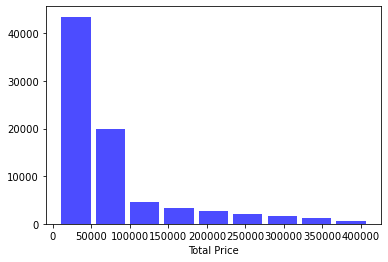

In [50]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=train['total_price_cents'], bins=9, color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Total Price")
plt.show()

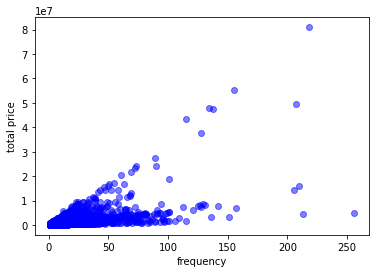

In [16]:
# Create the scatter plot for age and amount
plt.scatter(train_df['frequency'], train_df['total_price_cents'], c='blue', alpha=0.5)
plt.xlabel("frequency")
plt.ylabel("total price")
plt.show()

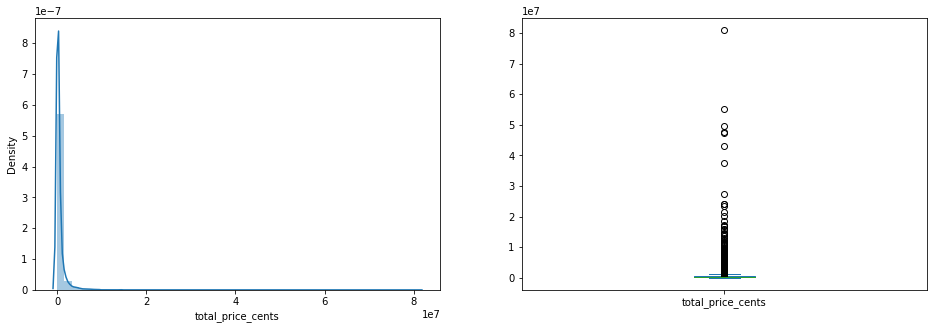

In [17]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.distplot(train_df['total_price_cents'])

plt.subplot(122)
train_df['total_price_cents'].plot.box(figsize=(16,5))

plt.show()

It can be inferred that most of the data in the distribution of the buyers total price is towards left which means it is not normally distributed. The box-plot confirms the presence of a lot of outliers/extremes values. This can be attributed to the price disparity of different merchants products

In [51]:
# Function to find percentage of missing in each feature.
def find_missing(data):
    count_missing = data.isnull().sum().values
    total = data.shape[0]
    percent_missing = (count_missing/total) * 100
    return pd.DataFrame(data = {'missing_count':count_missing, 'percent_missing': percent_missing},
                       index = data.columns.values)

find_missing(train_df)

,missing_count,percent_missing
buyer_id,0,0.0
buyer_recency,0,0.0
frequency,0,0.0
total_price_cents,0,0.0
buyer_acceptance_rate,0,0.0
buyer_rejection_rate,0,0.0
nondefaultpercent,0,0.0
default_flag,0,0.0


In [52]:
# Encode the values of the default flag of the train set to zeros and ones
train_df.default_flag.replace(to_replace=['N', 'Y'], value=[0, 1], inplace=True)

In [53]:
# Encode the values of the default flag of the test set to zeros and ones
test_df.default_flag.replace(to_replace=['N', 'Y'], value=[0, 1], inplace=True)

In [54]:
# check the values at the end
train_df.tail(5)

,buyer_id,buyer_recency,frequency,total_price_cents,buyer_acceptance_rate,buyer_rejection_rate,nondefaultpercent,default_flag
9758,5,1087,2,85528.0,1.0,0.0,1.00000,0
9759,4,3,157,6853609.0,1.0,0.0,0.97006,0
9760,3,1090,1,37392.0,1.0,0.0,1.00000,0
9761,2,1090,1,46197.0,1.0,0.0,1.00000,0
9762,1,1091,1,36995.0,1.0,0.0,0.00000,1


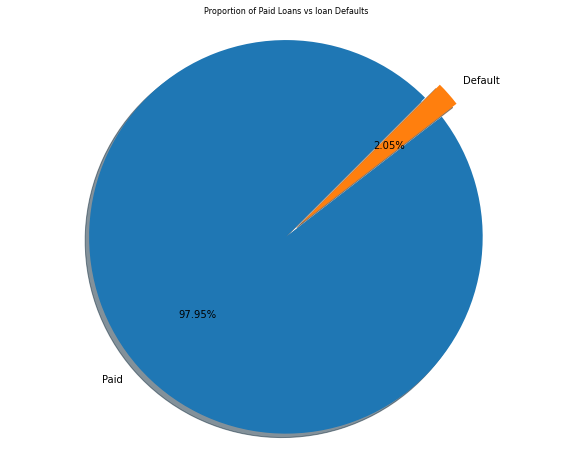

In [55]:
# Check the proportion of the target variable 
labels = 'Paid', 'Default'
sizes = [train_df.default_flag[train_df['default_flag']==0].count(), train_df.default_flag[train_df['default_flag']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=45)
ax1.axis('equal')
plt.title("Proportion of Paid Loans vs loan Defaults", size = 8)
plt.show()

At approximately 98% to 2.05%, It is clear that the dataset is biased toward the class (1). In order to have a good model, we will need to handle the imbalance in the dataset using two approaches

1. OverSampling
2. Undersampling
Due to the number of cases (especially the size of the minoruity class = 205)that we have for training. Oversampling is preferred as undersampling might not give the model enough diveristy.

In [56]:
train_df.shape, test_df.shape

((9763, 8), (1227, 13))

In [58]:
# Drop columns with no direct impact on the target variable
train_df.drop(['first_name', 'last_name', 'email', 'merchant_name', 'merchant_id'], axis = 1, inplace=True)

In [25]:
# Drop columns with no direct impact on the target variable
test_df.drop(['first_name', 'last_name', 'email', 'merchant_name', 'merchant_id'], axis = 1, inplace=True)

In [26]:
# Split features and value
# when trying to predict column "target" 
X_train, y_train = train_df.drop("default_flag", axis=1), train_df["default_flag"]
X_test, y_test = test_df.drop("default_flag", axis=1), test_df["default_flag"]

columns = X_train.columns

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(random_state=123, penalty='l2')
model.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [29]:
# Predict
pred = model.predict(X_test)

In [30]:
# Score
accuracy = model.score(X_test, y_test)

In [31]:
print(accuracy)

0.9665851670741646


In [32]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, pred))

[[1186    0]
 [  41    0]]


In [33]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1186
           1       0.00      0.00      0.00        41

    accuracy                           0.97      1227
   macro avg       0.48      0.50      0.49      1227
weighted avg       0.93      0.97      0.95      1227



## Handling Imbalance Using SMOTE

1. Oversampling

In [34]:
from imblearn.over_sampling import SMOTE, SMOTENC

smote_algo = SMOTE(random_state=0, k_neighbors=10)
os_data_X, os_data_y = smote_algo.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y= pd.DataFrame(data=os_data_y, columns=["default_flag"])

print('Length of Oversampled data is ', len(os_data_X))
print('Length of No Click in Oversampled data is ', len(os_data_y[os_data_y['default_flag'] == 0]))
print('Length of Clicks in Oversampled data is ', len(os_data_y[os_data_y['default_flag'] == 1]))

Length of Oversampled data is  19126
Length of No Click in Oversampled data is  9563
Length of Clicks in Oversampled data is  9563


In [36]:
from sklearn.model_selection import train_test_split
os_X_train, os_X_val, os_y_train, os_y_val = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=123)

In [37]:
os_logreg_model = LogisticRegression(random_state=123, penalty='l2')
os_logreg_model.fit(os_X_train, os_y_train)
os_y_pred = os_logreg_model.predict(os_X_val)
print(confusion_matrix(os_y_val,os_y_pred))
print(classification_report(os_y_val,os_y_pred))

[[1465 1408]
 [ 514 2351]]
              precision    recall  f1-score   support

           0       0.74      0.51      0.60      2873
           1       0.63      0.82      0.71      2865

    accuracy                           0.67      5738
   macro avg       0.68      0.67      0.66      5738
weighted avg       0.68      0.67      0.66      5738



In [38]:
pred_test = os_logreg_model.predict(X_test)

In [39]:
print(confusion_matrix(y_test,pred_test))
print(classification_report(y_test,pred_test))

[[311 875]
 [ 12  29]]
              precision    recall  f1-score   support

           0       0.96      0.26      0.41      1186
           1       0.03      0.71      0.06        41

    accuracy                           0.28      1227
   macro avg       0.50      0.48      0.24      1227
weighted avg       0.93      0.28      0.40      1227



In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

In [44]:
os_rf_model = RandomForestClassifier(max_depth=8, n_estimators=100)
os_rf_model.fit(os_X_train, os_y_train)
os_rf_pred = os_rf_model.predict(os_X_val)
print(confusion_matrix(os_y_val,os_rf_pred))
print(classification_report(os_y_val,os_rf_pred))

[[2873    0]
 [   0 2865]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2873
           1       1.00      1.00      1.00      2865

    accuracy                           1.00      5738
   macro avg       1.00      1.00      1.00      5738
weighted avg       1.00      1.00      1.00      5738



In [45]:
os_d_train = lgb.Dataset(os_X_train, label=os_y_train)
params = {}
params['learning_rate'] = 0.0001
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
# params['sub_feature'] = 0.5
params['num_leaves'] = 100
# params['min_data'] = 50
params['max_depth'] = 10

os_clf = lgb.train(params, os_d_train, 1000)
os_y_pred = os_clf.predict(os_X_val)

for i in range(0,len(os_y_val)):
    if os_y_pred[i]<0.5:
        os_y_pred[i]=0
    else:  
        os_y_pred[i]=1
        
print(confusion_matrix(os_y_val,os_y_pred))
print(classification_report(os_y_val,os_y_pred))

[LightGBM] [Info] Number of positive: 6698, number of negative: 6690
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 13388, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500299 -> initscore=0.001195
[LightGBM] [Info] Start training from score 0.001195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

### Model Output Analysis

Having experimented with Logistic Regression, Random Forest, and LightGB models, it can be obeserved that while both the Random Forest and LightGBM produce really good results on the oversampled validation set, performance deteriorates on the holdout test set.

This could point to a number of factors:

The model overfits the training set.
The oversampled test set is too similar to the test set and possibly same observations in the training set exist in the test set.
With more extensive experimentation and model parameter tuning, it might be possible to fix these issues.

### Handle Imbalance Dataset using UnderSampling

In [59]:
minority_class_length = len(train_df[train_df['default_flag'] == 1])
print(minority_class_length)

200


In [60]:
majority_class_indices = train_df[train_df['default_flag'] == 0].index
print(majority_class_indices)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761],
           dtype='int64', length=9563)


In [63]:
random_majority_indices = np.random.choice(majority_class_indices,minority_class_length, replace =False)
print(len(random_majority_indices))

200


In [64]:
minority_class_indices = train_df[train_df['default_flag'] == 1].index
print(minority_class_indices)

Int64Index([  12,   19,   32,   48,   61,   74,   75,   98,  202,  274,
            ...
            9330, 9352, 9368, 9388, 9588, 9667, 9710, 9740, 9748, 9762],
           dtype='int64', length=200)


In [65]:
minority_class_indices = list(minority_class_indices)
random_majority_indices = list(random_majority_indices)

In [66]:
under_sample_indices = minority_class_indices + random_majority_indices

In [67]:
un_data = train_df.loc[under_sample_indices]
un_data.head()

,buyer_id,buyer_recency,frequency,total_price_cents,buyer_acceptance_rate,buyer_rejection_rate,nondefaultpercent,default_flag
12,9987,1,1,13357.0,1.0,0.0,0.0,1
19,9980,1,1,39031.0,1.0,0.0,0.0,1
32,9967,2,1,44760.0,1.0,0.0,0.0,1
48,9951,3,1,45292.0,1.0,0.0,0.0,1
61,9938,4,1,16642.0,1.0,0.0,0.0,1


In [68]:
X = un_data.drop('default_flag', axis=1)
X = pd.get_dummies(X)
y = un_data['default_flag']
cn_X_train, cn_X_val, cn_y_train, cn_y_val = train_test_split(X, y, test_size=0.3, random_state=123)

In [69]:
un_logreg_model = LogisticRegression(random_state=123, penalty='l2')
un_logreg_model.fit(cn_X_train, cn_y_train)
un_y_pred = un_logreg_model.predict(cn_X_val)
print(confusion_matrix(cn_y_val,un_y_pred))
print(classification_report(cn_y_val,un_y_pred))

[[34 26]
 [13 47]]
              precision    recall  f1-score   support

           0       0.72      0.57      0.64        60
           1       0.64      0.78      0.71        60

    accuracy                           0.68       120
   macro avg       0.68      0.68      0.67       120
weighted avg       0.68      0.68      0.67       120



In [70]:
un_logreg_pred = un_logreg_model.predict(X_test)
print(confusion_matrix(y_test,un_logreg_pred))
print(classification_report(y_test,un_logreg_pred))

[[336 850]
 [ 12  29]]
              precision    recall  f1-score   support

           0       0.97      0.28      0.44      1186
           1       0.03      0.71      0.06        41

    accuracy                           0.30      1227
   macro avg       0.50      0.50      0.25      1227
weighted avg       0.93      0.30      0.43      1227



### Random Forrest

In [71]:
un_rf_model = RandomForestClassifier(max_depth=8, n_estimators=100)
un_rf_model.fit(cn_X_train, cn_y_train)

RandomForestClassifier(max_depth=8)

In [72]:
un_y_pred = un_rf_model.predict(X_test)
print(confusion_matrix(y_test,un_y_pred))
print(classification_report(y_test,un_y_pred))

[[1186    0]
 [   0   41]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1186
           1       1.00      1.00      1.00        41

    accuracy                           1.00      1227
   macro avg       1.00      1.00      1.00      1227
weighted avg       1.00      1.00      1.00      1227



### LigtGBM

In [73]:
un_d_train = lgb.Dataset(cn_X_train, label=cn_y_train)
params = {}
params['learning_rate'] = 0.0001
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
# params['sub_feature'] = 0.5
params['num_leaves'] = 100
# params['min_data'] = 50
params['max_depth'] = 10

un_clf = lgb.train(params, un_d_train, 1000)
un_y_pred = un_clf.predict(cn_X_val)

for i in range(0,len(cn_y_val)):
    if un_y_pred[i]<0.5:
        un_y_pred[i]=0
    else:  
        un_y_pred[i]=1
        
print(confusion_matrix(cn_y_val,un_y_pred))
print(classification_report(cn_y_val,un_y_pred))

[LightGBM] [Info] Number of positive: 140, number of negative: 140
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

### Model Analysis

Having experimented with Logistic Regression, Random Forest, and LightGB models on the undersampled dataset, we can see that the model perform just as the oversampled. This is due to the fact that the undersample data is too small to represent the entire population.

### Model Selection


The Models Approach have similiar performance in term of accuracy and ability to genralise the training set. Since the aim of this analysis is to predict delinquency, we can do a further analysis. To achive this further analysis will be done to the confusion matrix to select the model with the best performance using a cost based approach.

The Oversampled Logistic regression is the best model in term of predicting one in a cost efficient manner

Further Approaches can also be used to revalidate the model performance, they are:

1. AUC ROC
2. Youden Index

## 4. Fit a model, recalibrate it, and evaluate it in your dataset splits

In [ ]:
os_logreg_model = LogisticRegression(random_state=123, penalty='l2')
os_logreg_model.fit(os_X_train, os_y_train)
os_y_pred = os_logreg_model.predict(os_X_val)
print(confusion_matrix(os_y_val,os_y_pred))
print(classification_report(os_y_val,os_y_pred))

In [76]:
df_features = train_df.drop('default_flag', axis=1)
df_features = pd.get_dummies(df_features)
pred = os_logreg_model.predict(df_features)
pred_prob = os_logreg_model.predict_proba(df_features)

In [78]:
final_df = train_df.copy()
final_df.reset_index(drop=True, inplace=True)
final_df['predictions'] = pred
final_df['prediction_probabilities'] = pred_prob[:,1]

In [79]:
final_df.head()

,buyer_id,buyer_recency,frequency,total_price_cents,buyer_acceptance_rate,buyer_rejection_rate,nondefaultpercent,default_flag,predictions,prediction_probabilities
0,10000,0,1,21915.0,1.0,0.0,1.0,0,1,0.669487
1,9999,0,1,8249.0,1.0,0.0,1.0,0,1,0.685085
2,9998,0,1,47798.0,1.0,0.0,1.0,0,1,0.638847
3,9997,0,1,170483.0,1.0,0.0,1.0,0,0,0.482206
4,9996,0,1,340644.0,1.0,0.0,1.0,0,0,0.276675


### 5. build your features in SQL, and make sure that they are correct

In [80]:
import os
from sqlalchemy import create_engine
import pandas as pd

# Create connection based on environment variables defined at docker-compose.yml
conn_url = "postgresql+psycopg2://%s:%s@db:5432/%s" % (
    os.environ["POSTGRES_USER"],
    os.environ["POSTGRES_PASSWORD"],
    os.environ["POSTGRES_DB"]
)
engine = create_engine(conn_url, isolation_level="AUTOCOMMIT")

In [81]:
# Write the final prediction table to database
final_df.to_sql('final_df', con=engine, if_exists='replace',index=False)

763

In [82]:

def buyers_recency(buyer_id: int, merchant_id: int, total_price_cents: int, created_at: str) -> str:
    return f"""
    WITH source AS (
        SELECT
            buyer_id,
            buyer_recency
        FROM final_df
        WHERE
            buyer_id = {buyer_id}
            
    )
    SELECT total_price_cents > {total_price_cents} AS buyer_last_order_is_more_expensive
    FROM source
    WHERE buyer_recency = 1
    """